# Working with audio data


To begin working with audio datasets, make sure you have the Datasets
library installed:

In [13]:
!pip install datasets
!pip install torchcodec torchaudio
!pip install librosa


  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached soundfile-0.13.1-py2.py3-none-macosx_11_0_arm64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-1.0.0-cp312-abi3-macosx_11_0_arm64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 11.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 12.7 MB/s  0:00:02m0:00:0100:01
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
   ━━━━━━━

One of the key defining features of 🤗 Datasets is the ability to
download and prepare a dataset in just one line of Python code using the
`load_dataset()` function.

Let’s load and explore and audio dataset called
[MINDS-14](https://huggingface.co/datasets/PolyAI/minds14), which
contains recordings of people asking an e-banking system questions in
several languages and dialects.

To load the MINDS-14 dataset, we need to copy the dataset’s identifier
on the Hub (`PolyAI/minds14`) and pass it to the `load_dataset`
function. We’ll also specify that we’re only interested in the
Australian subset (`en-AU`) of the data, and limit it to the training
split:

In [4]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

The dataset contains 654 audio files, each of which is accompanied by a
transcription, an English translation, and a label indicating the intent
behind the person’s query. The audio column contains the raw audio data.
Let’s take a closer look at one of the examples:

In [6]:
example = minds[0]
example

{'path': 'en-AU~PAY_BILL/response_4.wav',
 'audio': <datasets.features._torchcodec.AudioDecoder at 0x12041c190>,
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

Got it — let me unpack this in simple terms with context:

---

> *Note*: When you work with audio in Datasets, each example might store the audio in **two possible ways**:

1. **As a lazy loader (`AudioDecoder`)**

   * `example["audio"]` is not the raw audio yet.
   * It just knows *where* the file is (path, format, metadata).
   * You must call `.decode()` to actually load the waveform into memory.
   * After decoding, you get a dict like:

     ```python
     {
       "path": ".../file.wav",
       "array": numpy_array_of_samples,
       "sampling_rate": 16000
     }
     ```

2. **As an already loaded dict**

   * Sometimes the dataset has been “cast” with `Audio(...)`, so `example["audio"]` is already that dict.
   * In that case, no need to `.decode()` — just use it directly.

---

* **`.decode()` loads the actual audio samples** (the big array of floats).
* This can be **slow and memory-hungry** if you do it for every single example in a big dataset.
* That’s why you don’t call it one-by-one in a loop.

* The recommended code checks:

  * If it’s an `AudioDecoder` → call `.decode()`.
  * If it’s already a dict → just use it.
* This way your code works regardless of dataset format.

---


You may notice that the audio column contains several features. Here’s
what they are: \* `path`: the path to the audio file (`*.wav` in this
case). \* `array`: The decoded audio data, represented as a
1-dimensional NumPy array. \* `sampling_rate`. The sampling rate of the
audio file (8,000 Hz in this example).

The `intent_class` is a classification category of the audio recording.
To convert this number into a meaningful string, we can use the
`int2str()` method:


In [7]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

If you look at the transcription feature, you can see that the audio file indeed has recorded a person asking a question about paying a bill.

If you plan to train an audio classifier on this subset of data, you may not necessarily need all of the features. For example, the `lang_id` is
going to have the same value for all examples, and won’t be useful. The `english_transcription` will likely duplicate the `transcription` in this subset, so we can safely remove them.

You can easily remove irrelevant features using 🤗 Datasets’
`remove_columns` method:

In [8]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

To listen to audio samples, we can use the `Audio` widget from
`Gradio`. 

In [10]:
!pip install Gradio

  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached ffmpy-0.6.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached groovy-0.1.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4.2 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached starlette-0.48.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tomlkit-0.13.3-py3-none-any.whl.metadata (2.8 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 5.0 MB/s  0:00:12m0:00:0100:01
Using cached aiofiles-24.1.0-py3-none-any.whl (15 kB)
Using cached groovy-0.1.2-py3-none-any.whl (14 kB)
Using cached safehttpx-0.1.6-py3-none-any.whl (8.7 kB)
Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
Using c

In [11]:
import gradio as gr


def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

/Users/e5028514/mariaaise/.venv/lib/python3.13/site-packages/gradio/processing_utils.py:688: UserWarning: Trying to convert audio automatically from float32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))
/Users/e5028514/mariaaise/.venv/lib/python3.13/site-packages/gradio/processing_utils.py:688: UserWarning: Trying to convert audio automatically from float32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))
/Users/e5028514/mariaaise/.venv/lib/python3.13/site-packages/gradio/processing_utils.py:688: UserWarning: Trying to convert audio automatically from float32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))
/Users/e5028514/mariaaise/.venv/lib/python3.13/site-packages/gradio/processing_utils.py:688: UserWarning: Trying to convert audio automatically from float32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


If you’d like to, you can also visualize some of the examples. Let’s
plot the waveform for the first example.

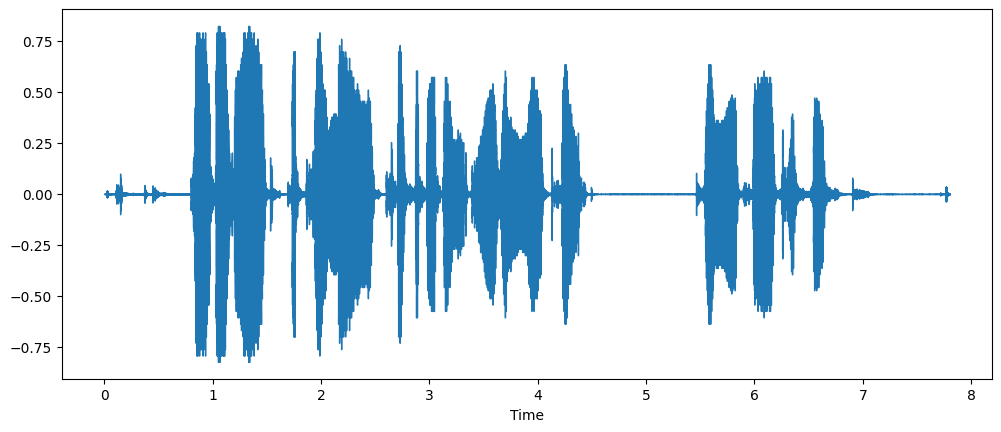

In [14]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

## Preprocessing an audio dataset

To prep the audio data for training or inference, you will typically need to do the following:

* Resampling the audio data
* Filtering the dataset
* Converting audio data to model's expected input

### Resampling the audio data

The `load_dataset` function downloads audio examples with the sampling rate that they were published with. This is not
always the sampling rate expected by a model you use. If there's a discrepancy between
the sampling rates, you can resample the audio to the model's expected sampling rate.

>*Hint*: Most of the available pretrained models have been pretrained on audio datasets at a sampling rate of 16 kHz.

Our dataset is sampled at 8 kHz. To resample it use `cast_column` method. This operation does not change the audio in-place, but rather signals to datasets to resample the audio examples on the fly when they are loaded:

In [ ]:
print(example["audio"]["sampling_rate"])
print(example["audio"]["array"].shape) # (8000,)

In [18]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))


Re-load the first audio example in the MINDS-14 dataset, and check that it has been resampled to the desired `sampling rate`:


In [31]:
example = minds[0]

print(example["audio"]["sampling_rate"])
print(example["audio"]["array"].shape)  # (16000,)

16000
(124830,)


The array values are now also different. This is because we've now got twice the number of amplitude values for
every one that we had before.

>*Hint*:
💡 - When changing the sampling rate, note that there is a Nyquist limit.

**Nyquist limit = the ceiling of frequencies your sampling rate can handle safely.**
Everything above it gets bent into fake lower sounds (aliasing).

* **8 kHz sampling rate** → Nyquist limit = **4 kHz** → sound contains no frequencies above 4 kHz.
* **44.1 kHz (CD audio)** → Nyquist limit ≈ **22 kHz** → covers human hearing range (\~20 Hz–20 kHz).
* **16 kHz (speech models)** → Nyquist limit = **8 kHz** → enough for voice (speech intelligibility).
</Tip>

## Filtering the dataset

Filtering is another common pre-processing:
- filter out any examples longer than 20s to prevent out-of-memory errors when training a model.

In [37]:
example = minds[0]
audio = example["audio"].decode() if hasattr(example["audio"], "decode") else example["audio"]
duration_s = len(audio["array"]) / audio["sampling_rate"]
print("duration (s):", duration_s)

duration (s): 7.801875


>*Note*:
This is a conditional (ternary) expression that ensures you get a plain dict for the audio data whether the dataset stores it as an already-decoded dict or as a lazy AudioDecoder:

If `example["audio"]` has a `decode` method (i.e. it's an `AudioDecoder`), call `.decode()` to force-load and return a dict with keys like "path", "array", "sampling_rate".
Otherwise (already a dict), just use it as-is.

`.decode()` loads the audio array into memory (can be slow/large). Avoid calling it repeatedly over a large dataset — use .map() (batched, num_proc) to compute durations or features once.
This pattern is safe when you mix datasets that may or may not have been cast with `Audio(...)`.

In [38]:
def compute_duration(example):
    audio = example["audio"].decode() if hasattr(example["audio"], "decode") else example["audio"]
    return {"duration": len(audio["array"]) / audio["sampling_rate"]}

minds = minds.map(compute_duration)   # single-threaded

Map: 100%|██████████| 654/654 [00:01<00:00, 529.52 examples/s]


In [39]:
MAX_DURATION = 20.0
minds = minds.filter(lambda ex: ex["duration"] < MAX_DURATION)
# cleanup if you want
minds = minds.remove_columns(["duration"])

Filter: 100%|██████████| 654/654 [00:00<00:00, 4689.95 examples/s]


In [40]:
len(minds)

624

We can verify that dataset has been filtered down from 654 examples to 624.

## Pre-processing audio data

- Pre-trained models expect the raw data to be converted into input features. 

- The requirements for the input features may vary from one model to another — they depend on the model's architecture, and the data it was pre-trained with. 

- For every supported audio model, Transformers offer a feature extractor class that can convert raw audio data into the input features the model expects.


**Feature extractor**

**Example**: [Whisper](https://arxiv.org/pdf/2212.04356) is a pre-trained model for
automatic speech recognition (ASR) published in September 2022 by Alec Radford et al. from OpenAI.


* **Step 1: padding/truncating**

  * All audio resized to **30s** length.
  * Shorter → padded with zeros (silence).
  * Longer → truncated.
  * No attention mask needed (unlike most models) — Whisper learns to ignore silence directly.

* **Step 2: spectrograms**

  * Converts audio into **log-mel spectrograms**.
  * Mel scale = perceptual frequency axis.
  * Log scale (dB) = matches human loudness perception.

* **Result:**

  * Standardized inputs for the model.
  * Easy to apply with a few lines of code.

Load the feature extractor from the pre-trained Whisper checkpoint to have ready for our audio data:


In [41]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


A function to pre-process a single audio example by passing it through the `feature_extractor`.


In [42]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

Apply the data preparation function to all of our training examples:


In [43]:
minds = minds.map(prepare_dataset)
minds

Map: 100%|██████████| 624/624 [00:02<00:00, 240.62 examples/s]


Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

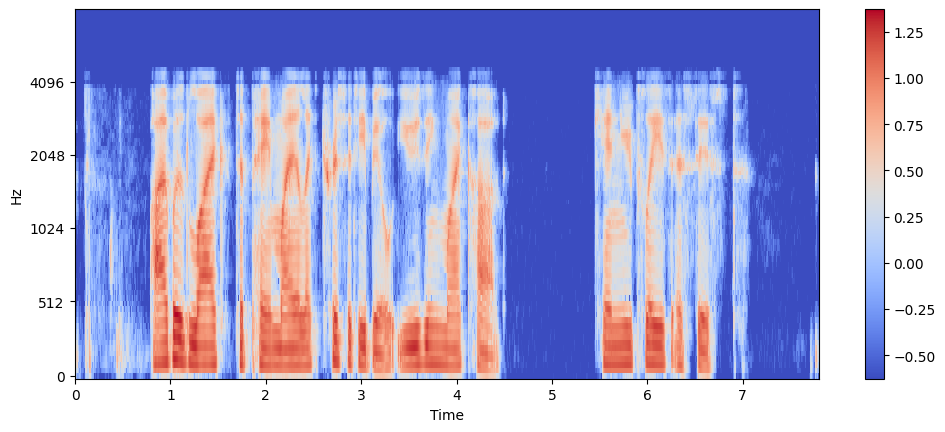

In [44]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

Load the feature extractor and tokenizer for Whisper and other multimodal models separately, or  load both via
a processor. 

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 13934.56it/s]
